In [1]:
using PyPlot
using LsqFit
include("../mc_julia.jl")

drop_the_mic (generic function with 1 method)

In [2]:
include("../compute_ttv.jl")
importall TTVFaster

### 0. Read and plot TTV data 

In [3]:
dat1 = readdlm("../ttv_planet1.txt")
t1 = dat1[:,1]
dat2 = readdlm("../ttv_planet2.txt")
t2 = dat2[:,1];

In [4]:
p_guesser(time::Array{Float64}) = mean(diff(time))
per_guess1 = p_guesser(t1)
per_guess2 = p_guesser(t2) ;

In [5]:
println(per_guess1,'\n',per_guess2)
# 5. venus and earth!

224.

In [6]:
reg_transits(t0::Float64,period::Float64,n_trans::Int64) = [t0+period*(i-1) for i=1:n_trans]
#returns regular transit times ;

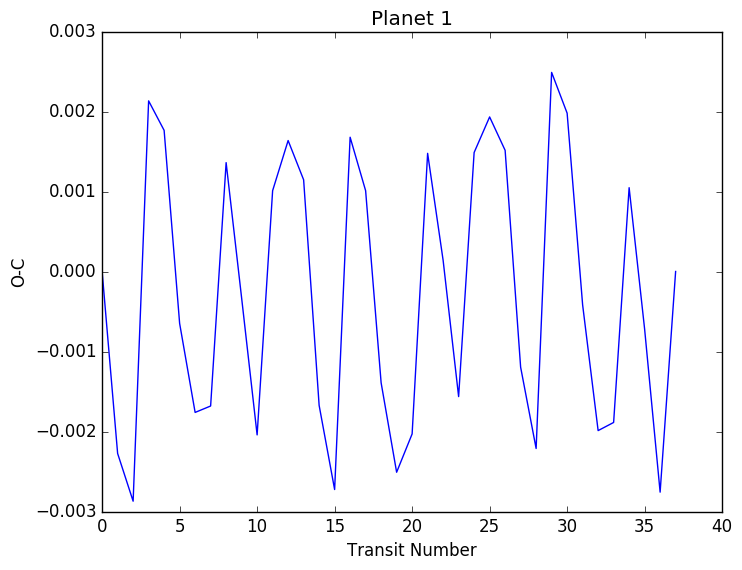

In [7]:
plot(t1-reg_transits(t1[1],per_guess1,length(t1)))
xlabel("Transit Number")
ylabel("O-C")
title("Planet 1") ;

70076641863517
365.25630708152175


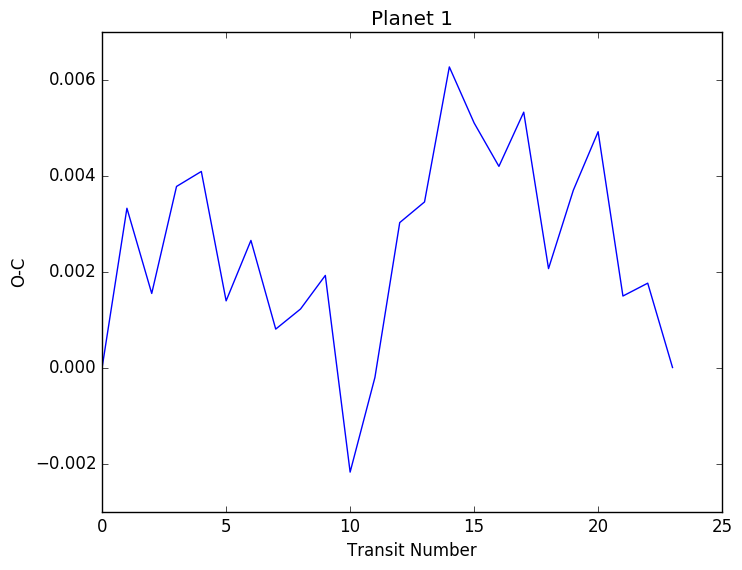

In [8]:
plot(t2-reg_transits(t2[1],per_guess2,length(t2)))
xlabel("Transit Number")
ylabel("O-C")
title("Planet 1") ;

### 1. Create a wrapper for compute_ttv.jl which calls N(N-1) pairs of planets to compute the TTV of each planet due to all of the others.

In [9]:
function make_plane(mass_ratio::Float64,period::Float64,t0::Float64,ecosw::Float64,esinw::Float64)
    plane = Planet_plane_hk(mass_ratio, period, t0, ecosw, esinw)
    return plane
end

make_plane (generic function with 1 method)

In [51]:
function compute_ttv_pairs(n_p::Int64,jmax::Int64,planets::Array{TTVFaster.Planet_plane_hk{Float64},1},times::Array{Array{Float64},1})
    ttvs = [zeros(length(time)) for time in times]
    c_times = copy(times)
    for i=1:n_p-1 #for each planet
        for j=i:n_p #go to each other planet
            if i!= j #make sure its not this planet
                ttv_ins = Array{Float64}[zeros(length(c_times[i])),zeros(length(c_times[j]))]
                compute_ttv!(jmax,planets[i],planets[j],c_times[i],c_times[j],ttv_ins[1],ttv_ins[2]) #compute ttvs, add to array
                ttvs[i] .+= ttv_ins[1] #add on to the TTVs
                ttvs[j] .+= ttv_ins[2]
                c_times[i] .-= ttv_ins[1] #subtract off from the times we're putting into compute_ttv!
                c_times[j] .-= ttv_ins[2]
            end
        end
    end
    return ttvs
end

compute_ttv_pairs (generic function with 1 method)

In [41]:
#Testing model works
plane1 = make_plane(.01,per_guess1,1.,0.1,0.1)
plane2 = make_plane(.01,per_guess2,1.,0.1,0.1)
plane_test = make_plane(0.1,500.0,1.,0.1,0.1)

3

In [52]:
times = Array{Float64}[t1,t2,[0.0]]
planes = [plane1,plane2,plane_test]
ttvs = compute_ttv_pairs(3,10,planes,times)

3-element Array{Array{Float64,1},1}:
 [-3.52325,10.6683,-25.8402,-10.2616,-23.9742,-40.0344,-20.098,44.5444,41.2446,23.3961  …  39.9186,26.3746,19.2134,-22.4851,-20.0752,-19.9682,-9.21128,1.0734,8.71888,18.1644]  
 [-306.982,-224.971,-106.878,477.414,173.71,106.222,-74.1825,578.919,166.826,-77.8213  …  -53.6499,-155.043,-55.5441,-85.2423,796.451,346.622,85.3438,-348.615,159.338,-31.2445]
 [-35.57051735068554]                                                                                                                                                           

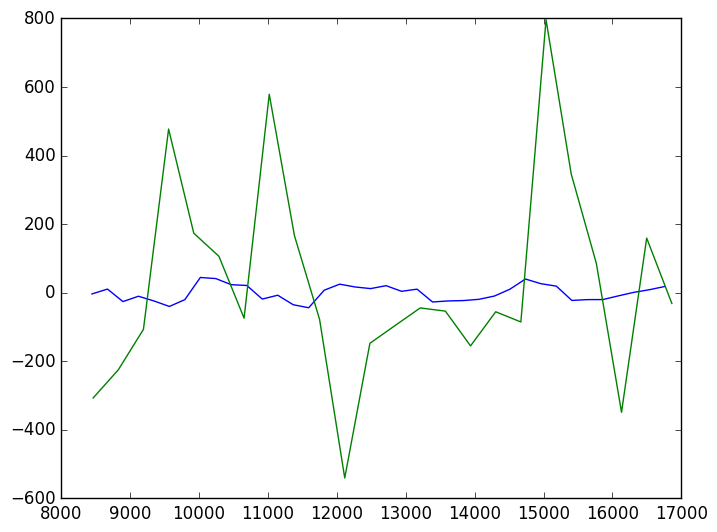

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31c1dac50>

In [57]:
plot(t1,ttvs[1])
plot(t2,ttvs[2])

### 2. Carry out an initial fit to the transit times of the two planets.

In [58]:
function fit_ttvs(n_p::Int64,jmax::Int64,times::Array{Array{Float64}})
        
    #1D array of times to make fitting easier
    lintimes = Float64[]
    for i=1:n_p
        append!(lintimes,times[i])
    end
    
    weights = [1.0/(0.000347222^2.0) for i=1:length(lintimes)] #30 second precision
    
    p0 = zeros(5*n_p)
    #initialize params
    #p[1]-p[5] = mass_ratio, period, t0, ecosw, esinw, first planet
    #p[6] - p[10] = same params but second planet
    for i=1:n_p
        p0[1+5*(i-1)] = 0.01
        p0[2+5*(i-1)] = p_guesser(times[i])
        p0[3+5*(i-1)] = times[i][1]
        p0[4+5*(i-1)] = 0.1
        p0[5+5*(i-1)] = 0.1
    end
        
    function ttv_model(times::Array{Array{Float64}},p::Array{Float64})
        planes = TTVFaster.Planet_plane_hk{Float64}[make_plane(p[1+5*(i-1)],p[2+5*(i-1)],p[3+5*(i-1)],p[4+5*(i-1)],p[5+5*(i-1)]) for i=1:n_p]
        ttvs = compute_ttv_pairs(n_p,jmax,planes,times) 
        reg_trans = Array{Float64}[reg_transits(p[3+5*(i-1)],p[2+5*(i-1)],length(times[i])) for i=1:n_p] #regular transits
        returned = Float64[]
        for i=1:n_p
            append!(returned,reg_trans[i].+ttvs[i])
        end
        return returned #regular transits plus the TTVS
    end
    
    fit = curve_fit(ttv_model,times,lintimes,weights,p0)
    
end

fit_ttvs (generic function with 1 method)

In [59]:
result = fit_ttvs(2,10,times) ;

In [60]:
parnames = ["M_1","P_1","t0_1","ecosw_1","esinw_1","M_2","P_2","t0_2","ecosw_2","esinw_2"]
for (nam,par) in zip(parnames,result.param)
    println("$nam = $par")
end

M_1 = 2.235171449693008e-6
P_1 = 224.700770451882
t0_1 = 8445.499522462233
ecosw_1 = 0.00726238040173944
esinw_1 = 0.003523727477478734
M_2 = 3.1241969491557223e-6
P_2 = 365.2563629205558
t0_2 = 8461.759186139672
ecosw_2 = 0.019592786798275887
esinw_2 = 0.006309613088096858


### 3. Add in a third (non-transiting) planet to your model.  Make a grid in period, and optimize the fit over periods from 500-10,000 days & over ~10 phases for each period.  Plot the maximum likelihood versus period. Note 3: you’ll need to create a wrapper for curve_fit which allows the 3rd period to be fixed.

### Lets edit our model such that we can account for asking for extra planets

to find third planet:
calculate residuals from O-C. so subtract TTVs from model then redo compute_ttv to find third nontransiting planet. 



In [17]:
#now n_p is one larger than the number of transiting planets we have. Lets fit them.
function fit_ttv_nontransit(n_p::Int64,jmax::Int64,times::Array{Array{Float64}})
    
    n_p_t = length(times) #number of transiting planets
    
    #add dummy array to times for non-transiting planet
    append!(times,Array{Float64}[[0.0]])
    
    #1D array of times to make fitting easier
    lintimes = Float64[]
    for i=1:n_p
        append!(lintimes,times[i])
    end
    
    weights = [1.0/(0.000347222^2.0) for i=1:length(lintimes)] #30 second precision
    
    #initialize params
    p0 = zeros(5*n_p_t)
    for i=1:n_p_t
        p0[1+5*(i-1)] = 0.01
        p0[2+5*(i-1)] = p_guesser(times[i])
        p0[3+5*(i-1)] = times[i][1]
        p0[4+5*(i-1)] = 0.1
        p0[5+5*(i-1)] = 0.1
    end
     #last three*non_transiting_planets parameters are planet mass and eccentricity vector components. We'll grid over period and t0
    push!(p0,0.01)
    push!(p0,0.1)
    push!(p0,0.1)
    
    
    P_grid = logspace(log10(500),4)
    phase_grid = collect(linspace(0.0,0.9,10))
    
    chi_best = 10000000.0
    P_best = 0.0
    t0_best = 0.0
    par_best = Float64[]
    
    for P in P_grid
        
        println(P)
        
        for phase in phase_grid
            
            println(phase)
            
            t0 = phase*P
            
            function ttv_model(times::Array{Array{Float64}},p::Array{Float64})
                skip = false
                for par in p
                    if par <= 0
                        skip = true
                    end
                end
                if skip
                    return Inf
                else
                    planes = TTVFaster.Planet_plane_hk{Float64}[make_plane(p[1+5*(i-1)],p[2+5*(i-1)],p[3+5*(i-1)],p[4+5*(i-1)],p[5+5*(i-1)]) for i=1:n_p_t]
                    push!(planes,make_plane(p[1+5*n_p_t],P,t0,p[2+5*n_p_t],p[3+5*n_p_t]))
                    ttvs = compute_ttv_pairs(n_p,jmax,planes,times) 
                    reg_trans = Array{Float64}[reg_transits(p[3+5*(i-1)],p[2+5*(i-1)],length(times[i])) for i=1:n_p_t] #regular transits
                    returned = Float64[]
                    for i=1:n_p_t #no transits for the other planets
                        append!(returned,reg_trans[i].+ttvs[i])
                    end
                    return returned #regular transits plus the TTVS  
                end
            end
            fit = curve_fit(ttv_model,times,lintimes,weights,p0) #fit, pull out parameters and chi2, if its the best, set P_best/best fit parameters equal to it
            chi2 = sum(fit.resid.^2*weights)
            if chi2 < chi_best
                chi_best = chi2
                P_best = P
                t0_best = t0
                par_best = fit.param
            end
        end
    end
    
    println(par_best,P_best,t0_best)
    
end

fit_ttv_nontransit (generic function with 1 method)

In [18]:
fit_ttv_nontransit(3,10,times)

P_1 = 224.700770451882
t0_1 = 8445.499522462233
ecosw_1 = 0.00726238040173944
esinw_1 = 0.003523727477478734
M_2 = 3.1241969491557223e-6
P_2 = 365.2563629205558
t0_2 = 8461.759186139672
ecosw_2 = 0.019592786798275887
esinw_2 = 0.006309613088096858
499.

LoadError: LoadError: AssertionError: alpha < 1
while loading In[18], in expression starting on line 1

In [19]:
splice!(foo,3,[20,foo[3]])

LoadError: LoadError: UndefVarError: foo not defined
while loading In[19], in expression starting on line 1

In [20]:
any(foo) > 0

99999999999994
0.0


LoadError: LoadError: UndefVarError: foo not defined
while loading In[20], in expression starting on line 1

In [21]:
logspace(log10(500),4)

50-element Array{Float64,1}:
   500.0  
   531.522
   565.032
   600.655
   638.523
   678.779
   721.572
   767.064
   815.423
   866.832
   921.481
   979.576
  1041.33 
     ⋮    
  5104.25 
  5426.05 
  5768.13 
  6131.79 
  6518.36 
  6929.31 
  7366.17 
  7830.57 
  8324.25 
  8849.05 
  9406.94 
 10000.0  